In [1]:
import numpy as np
import pandas
import h5py
import matplotlib.pyplot as plt
from corner import corner

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import numpyro
import optax

import bilby
import gwpopulation
gwpopulation.set_backend('jax')

In [3]:
jax.devices()

[cuda(id=0)]

## Load the data

In [4]:
def load_posteriors():
    posteriors = []
    
    with h5py.File(
        './o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_samples.hdf5', 'r',
    ) as f:

        samples = f['original']
        num_obs, num_samples = samples['a_1'].shape
        
        for n in range(num_obs):
            posterior = pandas.DataFrame()
            for par in samples:
                posterior[par] = samples[par][n, :]

            posteriors.append(posterior)
    
    return posteriors

In [5]:
def load_injections():
    cut_far = 1.0
    cut_snr = 10.0
    
    injections = {}
    
    with h5py.File(
        './o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5', 'r',
    ) as f:
        samples = f['injections']
    
        ifars = [
            samples[par][:] for par in samples.keys()
            if ('ifar' in par) and ('cwb' not in par)
            ]
        ifar = np.max(ifars, axis=0)
        snr = samples['optimal_snr_net'][:]
        runs = samples['name'][:].astype(str)
        found = np.where(runs == 'o3', ifar > 1/cut_far, snr > cut_snr)
    
        mass_1 = samples['mass1_source'][:][found]
        mass_2 = samples['mass2_source'][:][found]
        spin1x = samples['spin1x'][:][found]
        spin1y = samples['spin1y'][:][found]
        spin1z = samples['spin1z'][:][found]
        spin2x = samples['spin2x'][:][found]
        spin2y = samples['spin2y'][:][found]
        spin2z = samples['spin2z'][:][found]
        redshift = samples['redshift'][:][found]
    
        mass_ratio = mass_2 / mass_1
        a_1 = (spin1x**2 + spin1y**2 + spin1z**2)**.5
        a_2 = (spin2x**2 + spin2y**2 + spin2z**2)**.5
        cos_tilt_1 = spin1z / a_1
        cos_tilt_2 = spin2z / a_2
    
        injections['mass_1'] = mass_1
        injections['mass_ratio'] = mass_ratio
        injections['a_1'] = a_1
        injections['a_2'] = a_2
        injections['cos_tilt_1'] = cos_tilt_1
        injections['cos_tilt_2'] = cos_tilt_2
        injections['redshift'] = redshift
    
        prior = samples['sampling_pdf'][:][found]
        prior *= mass_1 * 4 * np.pi**2 * a_1**2 * a_2**2
        injections['prior'] = prior
    
        dodgy = injections['redshift'] > 1.9
        for par in injections:
            injections[par] = injections[par][~dodgy]
    
        injections['total_generated'] = samples.attrs['total_generated']
    
    for par in injections:
        injections[par] = jnp.array(injections[par])
    
    return injections

## Define the population model

In [6]:
from gwpopulation.models.mass import SinglePeakSmoothedMassDistribution
from gwpopulation.models.spin import iid_spin
from gwpopulation.models.redshift import PowerLawRedshift
from gwpopulation.experimental.jax import NonCachingModel

In [7]:
def spin_model(dataset, xi_spin, sigma_spin, alpha_chi, beta_chi):
    amax = 1.0
    return iid_spin(dataset, xi_spin, sigma_spin, amax, alpha_chi, beta_chi)

In [8]:
def make_model():
    models = [
        SinglePeakSmoothedMassDistribution(),
        spin_model,
        PowerLawRedshift(cosmo_model = 'Planck15'),
    ]
    return NonCachingModel(models)

## Define the population likelihood

In [9]:
from gwpopulation.vt import ResamplingVT
from gwpopulation.hyperpe import HyperparameterLikelihood

In [10]:
selection_function = ResamplingVT(
    model = make_model(),
    data = load_injections(),
    n_events = len(load_posteriors()),
    marginalize_uncertainty = False,
    enforce_convergence = False,
)

2024-08-07 15:16:55.611021: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [11]:
likelihood = HyperparameterLikelihood(
    posteriors = load_posteriors(),
    hyper_prior = make_model(),
    selection_function = selection_function,
    maximum_uncertainty = jnp.inf,
)

## Define the prior

In [12]:
priors = bilby.prior.PriorDict()
priors['alpha'] = bilby.prior.Uniform(-4, 12)
priors['beta'] = bilby.prior.Uniform(-2, 7)
priors['mmin'] = bilby.prior.Uniform(6.5, 10)
priors['mmax'] = bilby.prior.Uniform(65, 100)
priors['lam'] = bilby.prior.Uniform(0, 1)
priors['mpp'] = bilby.prior.Uniform(20, 50)
priors['sigpp'] = bilby.prior.Uniform(1, 10)
priors['delta_m'] = bilby.prior.Uniform(0, 10)
priors['lamb'] = bilby.prior.Uniform(-6, 6)
priors['alpha_chi'] = bilby.prior.Uniform(1, 10)
priors['beta_chi'] = bilby.prior.Uniform(1, 10)
priors['xi_spin'] = bilby.prior.Uniform(0, 1)
priors['sigma_spin'] = bilby.prior.Uniform(0.1, 4)

## Variational inference with numpyro and gwpopulation

In [13]:
from gwpopulation.experimental.numpyro import construct_numpyro_model

In [14]:
model = construct_numpyro_model(likelihood, priors)

In [15]:
# guide = numpyro.infer.autoguide.AutoNormal(model)
guide = numpyro.infer.autoguide.AutoBNAFNormal(
    model, num_flows = 1, hidden_factors = [8],
)
# optim = numpyro.optim.Adam(step_size = 1e-2)
optim = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(1e-2))
loss = numpyro.infer.Trace_ELBO(num_particles = 1, vectorize_particles = True)
svi = numpyro.infer.SVI(model, guide, optim, loss)

In [16]:
result = svi.run(
    rng_key = jax.random.PRNGKey(0),
    num_steps = 100,
    progress_bar = True,
    stable_update = True,
)

100%|█| 100/100 [00:16<00:00,  5.94it/s, init loss: 179769313486231570814527423731704356798070567525


/work/submit/mmould/miniforge3/envs/gpu/lib/python3.10/site-packages/matplotlib/axes/_base.py:2991: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


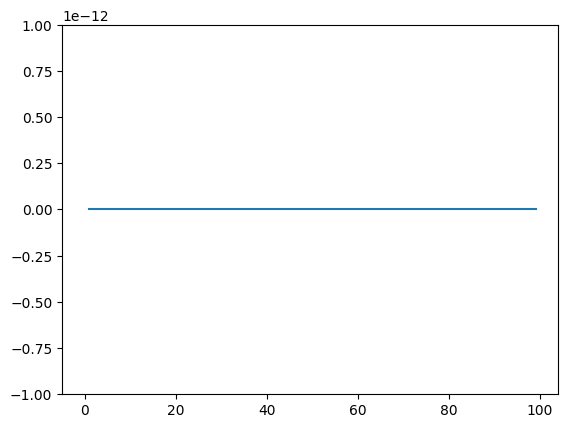

In [17]:
plt.plot(np.nan_to_num(result.losses));

## Manual numpyro model

In [248]:
from gwpopulation.experimental.numpyro import \
    bilby_to_numpyro_priors, sample_prior

In [249]:
numpyro_priors = bilby_to_numpyro_priors(priors)

In [68]:
hyper_prior = make_model()

In [54]:
posteriors = load_posteriors()
injections = load_injections()

In [55]:
nobs = len(posteriors)
nobs

69

In [73]:
posteriors = {
    par: jnp.array([p[par].values for p in posteriors])
    for par in posteriors[0].keys()
}

In [290]:
posteriors.keys(), injections.keys()

(dict_keys(['a_1', 'a_2', 'cos_tilt_1', 'cos_tilt_2', 'mass_1', 'mass_2', 'mass_ratio', 'prior', 'redshift', 'weights']),
 dict_keys(['mass_1', 'mass_ratio', 'a_1', 'a_2', 'cos_tilt_1', 'cos_tilt_2', 'redshift', 'prior', 'total_generated']))

In [480]:
def sample_svi(key, num_samples, guide, params):
    predictive = numpyro.infer.Predictive(
        guide, params = params, num_samples = 10_000,
    )
    samples = predictive(key)
    base = numpyro.distributions.Normal(0, 1)
    return {
        par: prior.icdf(base.cdf(samples[f'{par}_scaled']))
        for par, prior in numpyro_priors.items()
    }

#### train prior

In [515]:
def prior_model():
    parameters = sample_prior(numpyro_priors, [])

In [516]:
guide = numpyro.infer.autoguide.AutoBNAFNormal(
    prior_model, num_flows = 1, hidden_factors = [8],
)

optim = numpyro.optim.Adam(step_size = 1e-2)

loss = numpyro.infer.Trace_ELBO(
    num_particles = 10_000, vectorize_particles = True,
)

prior_svi = numpyro.infer.SVI(prior_model, guide, optim, loss)

In [517]:
prior_result = prior_svi.run(
    rng_key = jax.random.PRNGKey(1),
    num_steps = 10_000,
    progress_bar = True,
    stable_update = True,
)

100%|████| 10000/10000 [00:12<00:00, 805.49it/s, init loss: 10.6369, avg. loss [9501-10000]: 0.0040]


In [518]:
jnp.isfinite(prior_result.losses).all()

Array(True, dtype=bool)

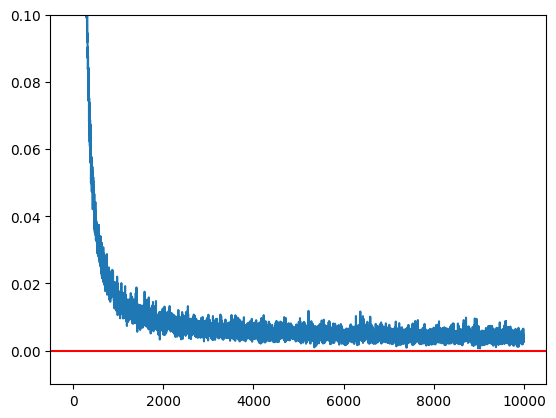

In [524]:
plt.plot(prior_result.losses);
plt.axhline(0, c = 'r');
# plt.semilogy();
plt.ylim(-1e-2, 1e-1);

In [540]:
samples = sample_svi(
    jax.random.PRNGKey(2), 10_000, prior_svi.guide, prior_result.params,
)

In [541]:
samples.keys()

dict_keys(['alpha', 'beta', 'mmin', 'mmax', 'lam', 'mpp', 'sigpp', 'delta_m', 'lamb', 'alpha_chi', 'beta_chi', 'xi_spin', 'sigma_spin'])

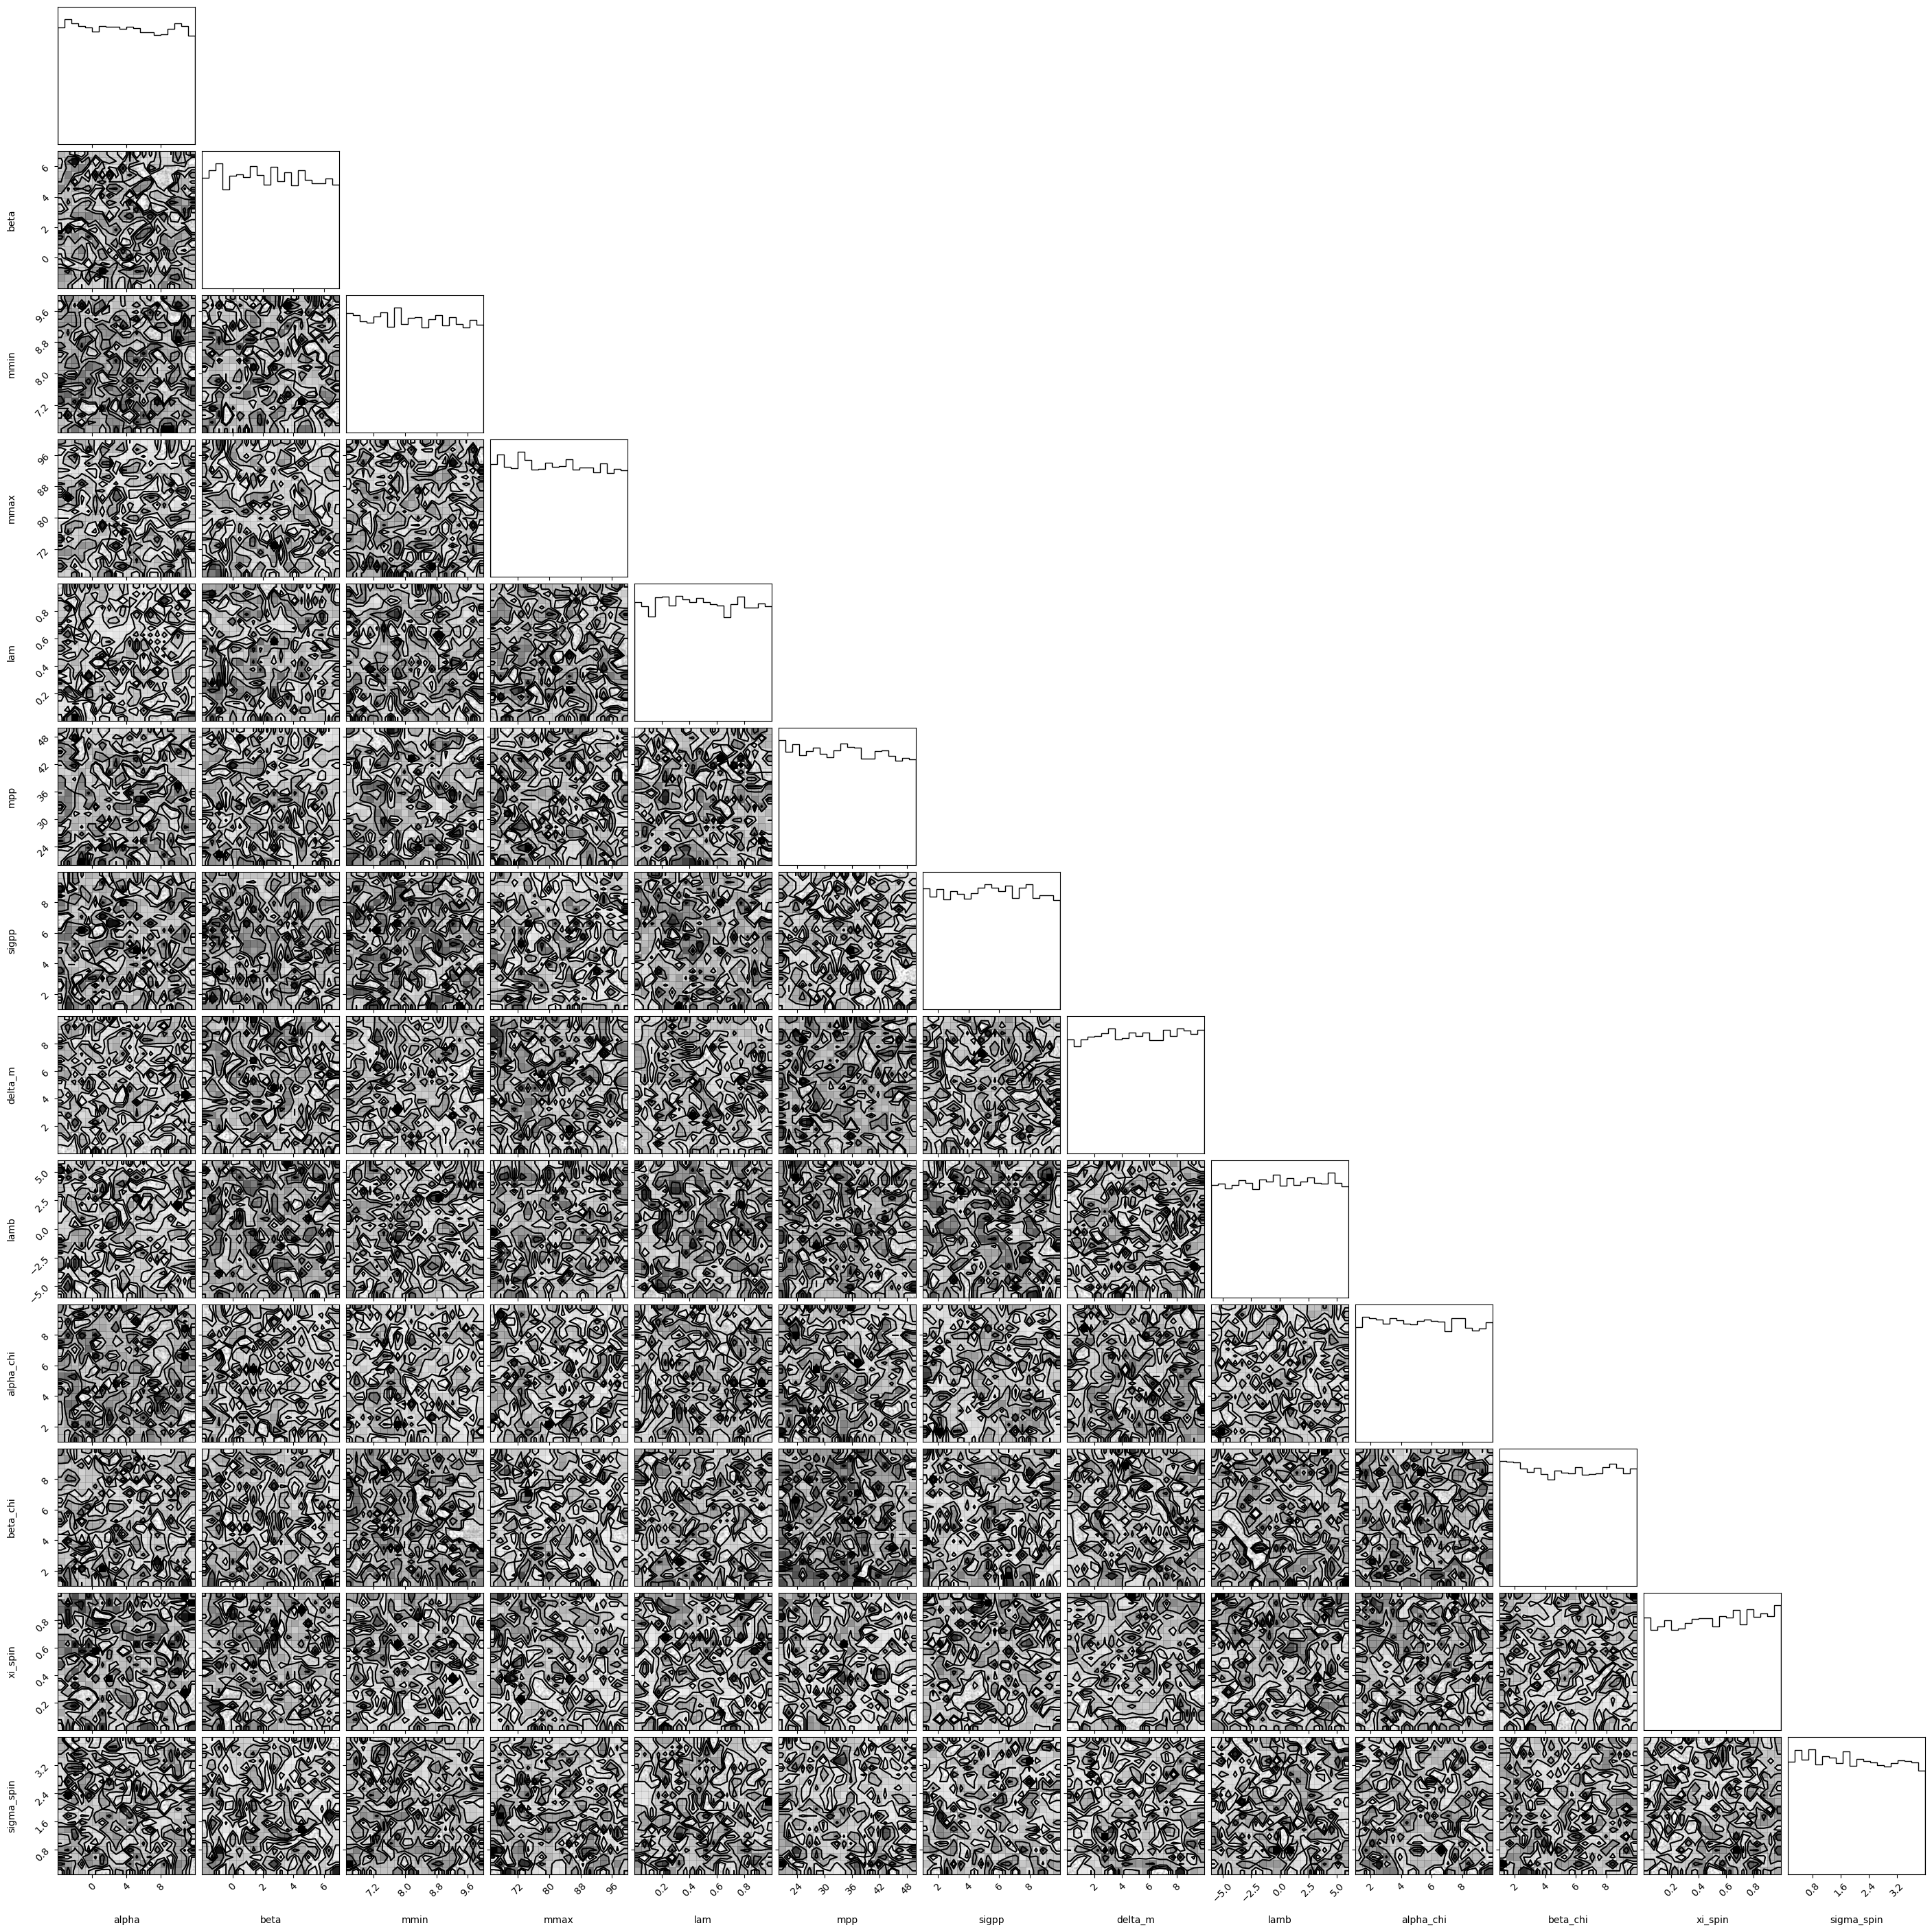

In [542]:
corner(np.transpose(list(samples.values())), labels = list(samples));

#### train posterior

In [564]:
def posterior_model():
    parameters = sample_prior(numpyro_priors, [])
    
    hyper_prior.parameters.update(parameters)

    weights = hyper_prior.prob(posteriors) / posteriors['prior']
    log_bfs = jnp.mean(weights, axis = 1)

    weights = hyper_prior.prob(injections) / injections['prior']
    pdet = jnp.sum(weights) / injections['total_generated']

    log_lkl = jnp.sum(log_bfs) - nobs * jnp.log(pdet)
    numpyro.factor('log_lkl', log_lkl)

In [565]:
guide = numpyro.infer.autoguide.AutoBNAFNormal(
    posterior_model, num_flows = 1, hidden_factors = [8],
)
init_params = prior_result.params
# guide = numpyro.infer.autoguide.AutoNormal(posterior_model)
# init_params = {}
# for par in priors:
#     init_params[f'{par}_scaled_auto_loc'] = jnp.zeros(())
#     init_params[f'{par}_scaled_auto_scale'] = jnp.ones(())

optim = optax.chain(
    # optax.clip_by_global_norm(1.0),
    optax.adam(1e-3),
)

loss = numpyro.infer.Trace_ELBO(
    num_particles = 10, vectorize_particles = True,
)
# loss = numpyro.infer.RenyiELBO(
#     alpha = 0, num_particles = 10_000, # vectorize_particles = True,
# )
# loss.vectorize_particles = True,

posterior_svi = numpyro.infer.SVI(posterior_model, guide, optim, loss)

In [566]:
posterior_result = posterior_svi.run(
    rng_key = jax.random.PRNGKey(3),
    num_steps = 10_000,
    progress_bar = True,
    stable_update = True,
    init_params = init_params,
)

100%|█| 10000/10000 [01:53<00:00, 87.82it/s, init loss: -320.1399, avg. loss [9501-10000]: -1040.728


In [567]:
jnp.isfinite(posterior_result.losses).all()

Array(True, dtype=bool)

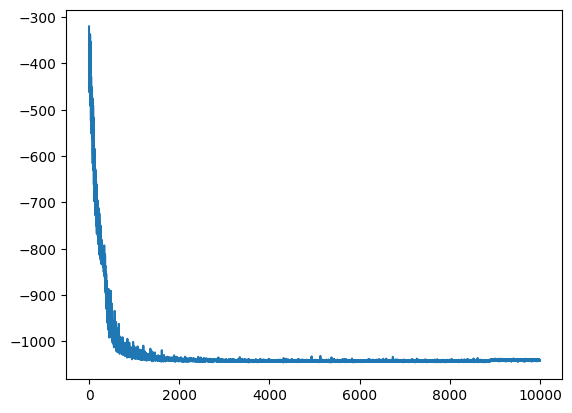

In [568]:
plt.plot(posterior_result.losses);

In [569]:
samples = sample_svi(
    jax.random.PRNGKey(4), 10_000, posterior_svi.guide, posterior_result.params,
)

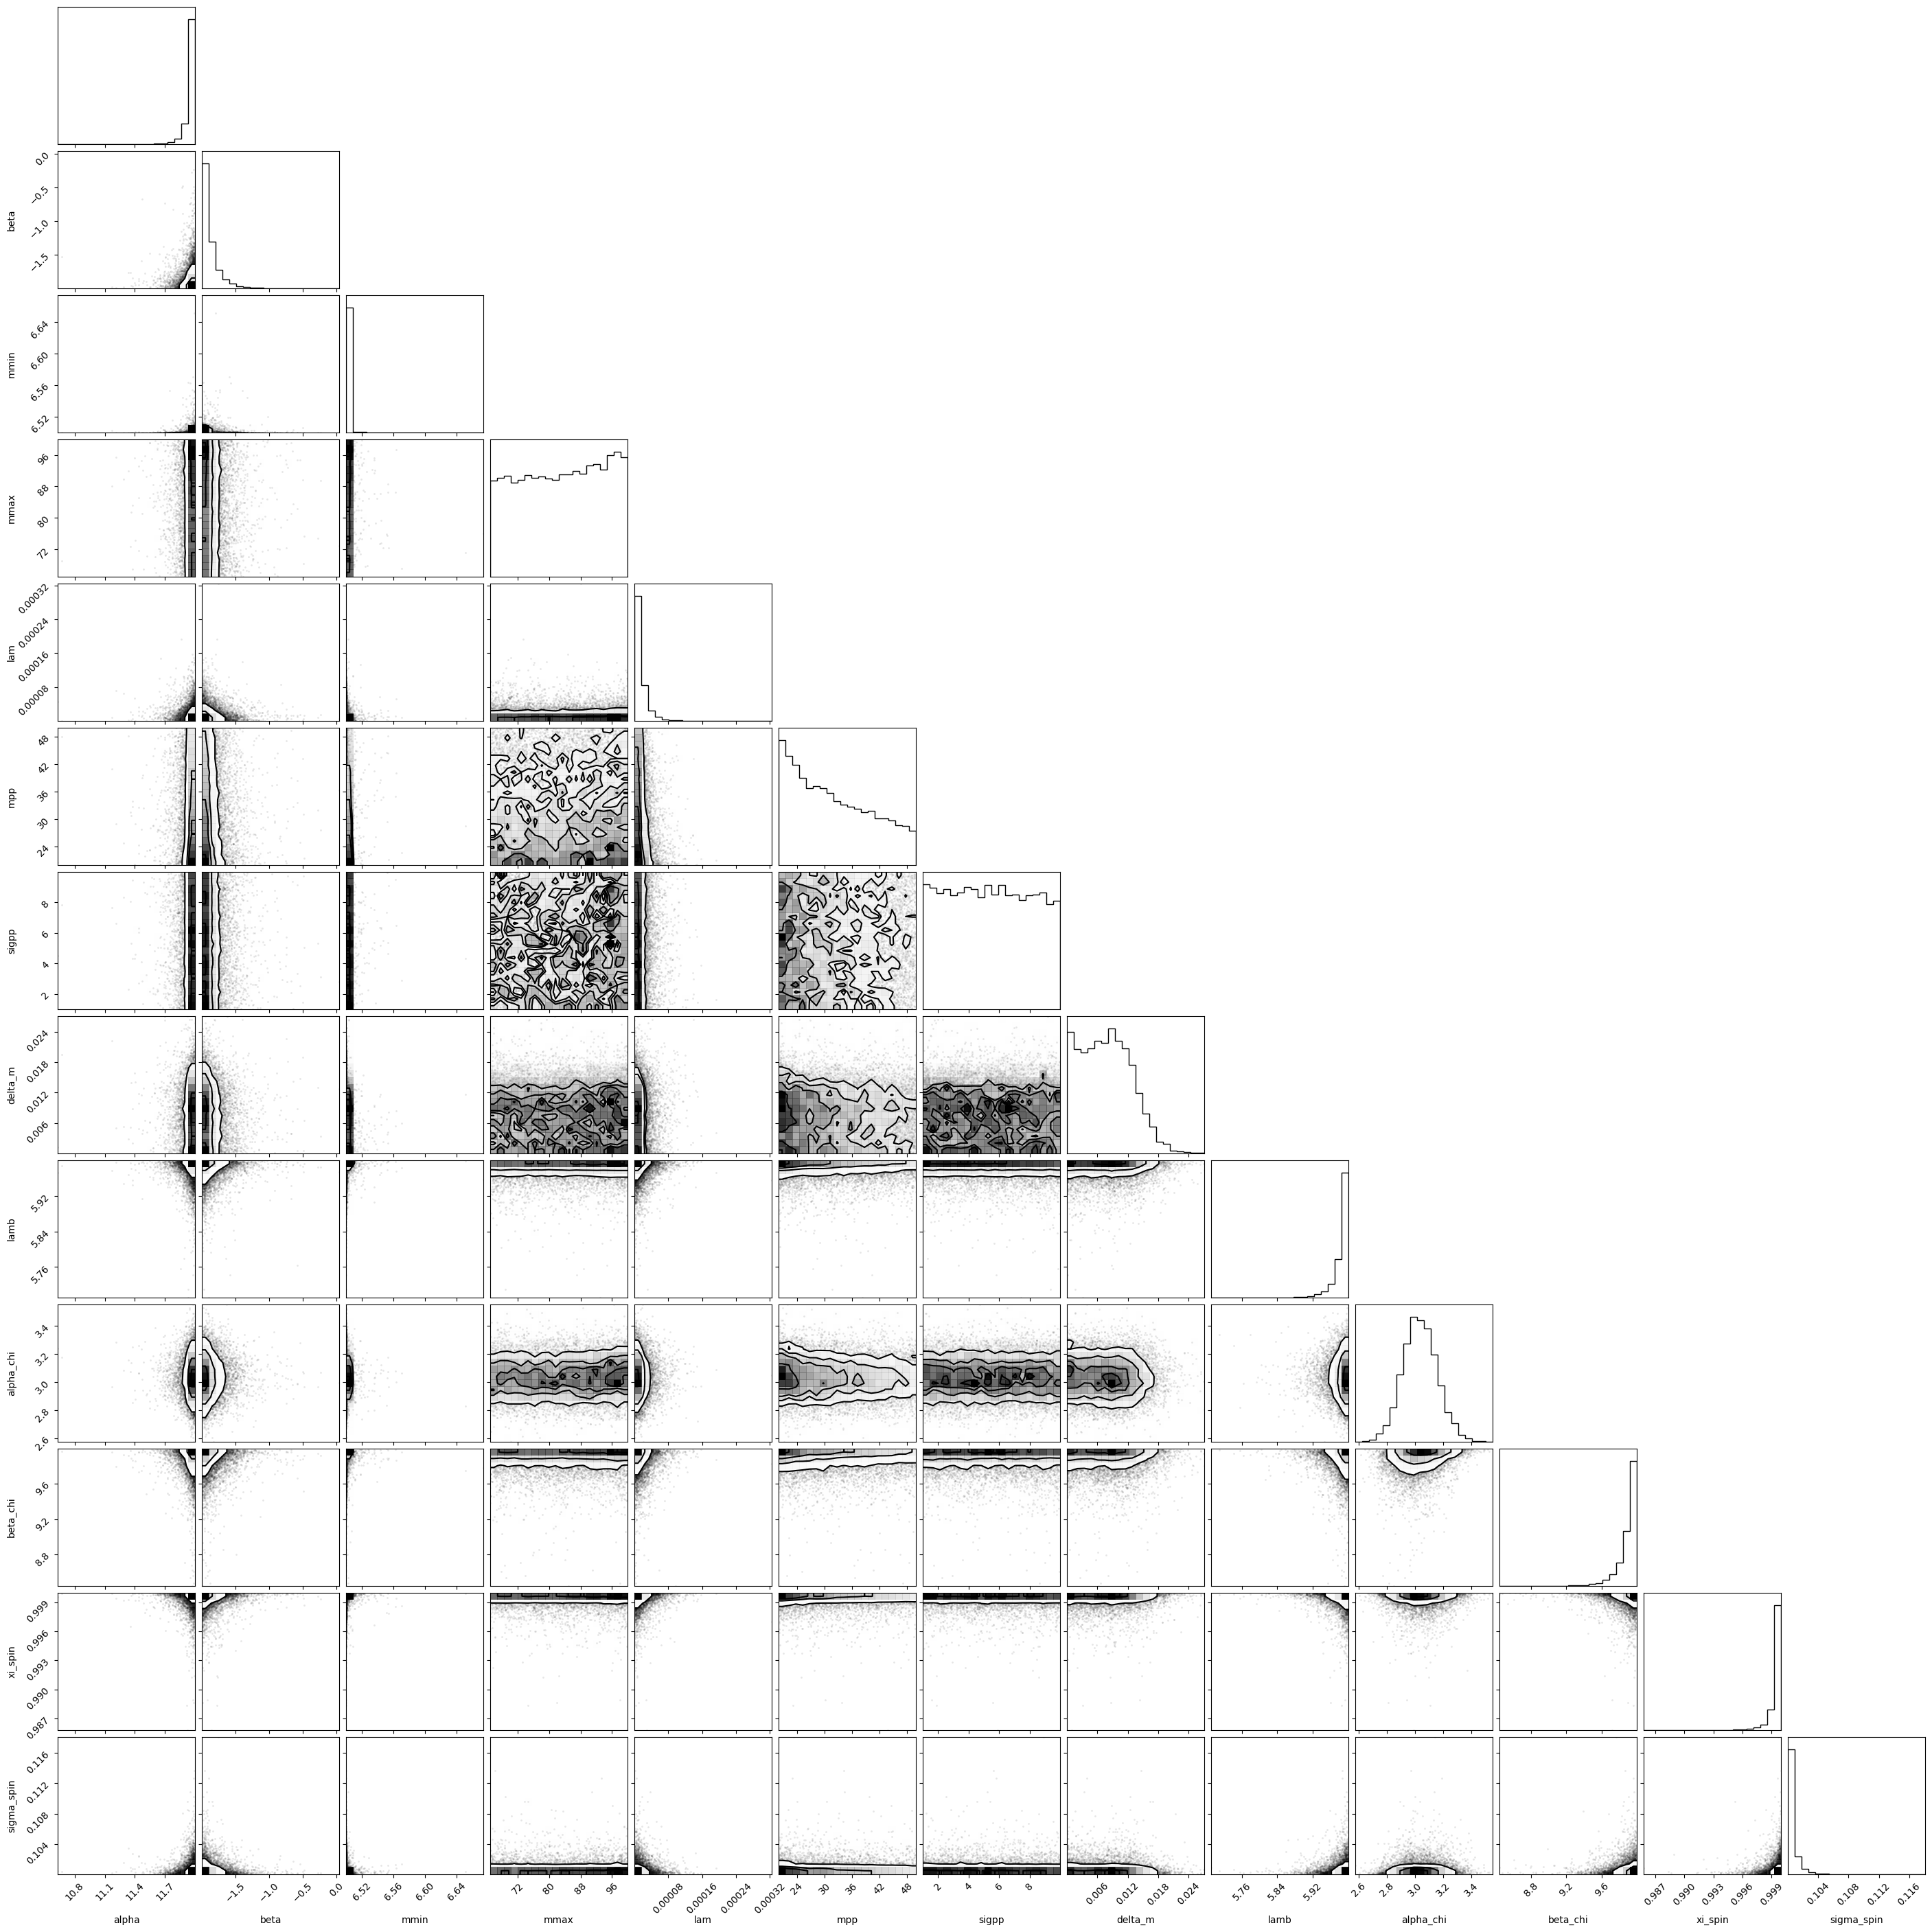

In [570]:
corner(np.transpose(list(samples.values())), labels = list(samples));